In [198]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [199]:
# Função para aplicar Local Binary Patterns (LBP)
def apply_lbp(image, radius=1.0, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method='ror')

    return lbp

def apply_hog(image):
    """Aplica HOG (Histogram of Oriented Gradients) em uma imagem e retorna as features."""
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                              cells_per_block=(2, 2), block_norm='L2-Hys', 
                              transform_sqrt=True, visualize=False)
    return features

# Função para extrair histogramas como feature
def extract_histogram(image):
    image_uint8 = np.uint8(image)
    hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 256])
    return cv2.normalize(hist, hist).flatten()


def load_images(folder):
    """Carrega as imagens de uma pasta sem extrair features, apenas armazena as imagens e labels."""
    images = []
    labels = []
    classes = os.listdir(folder)  # Assumindo que as subpastas são os labels (nomes das classes)
    
    for class_name in classes:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    labels.append(class_name)
    
    return images, np.array(labels)

def extract_features(images, feature_type='lbp'):
    """Aplica o tipo de extração de features (HOG ou LBP) nas imagens carregadas."""
    X = []
    for image in images:
        if feature_type == 'lbp':
            lbp_image = apply_lbp(image)
            lbp_image = lbp_image[2:-2, 2:-2]
            features = extract_histogram(lbp_image)
        elif feature_type == 'hog':
            features = apply_hog(image)
        X.append(features)
    return np.array(X)

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Função para mostrar imagem original, convolucionada e histograma
def show_image_convolution_histogram(image_path):
    # Carregar a imagem original
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Aplicar filtro convolucional
    convoluted_image = apply_lbp(image)
    convoluted_image = convoluted_image[2:-2, 2:-2]
    features = extract_histogram(convoluted_image)
    
    # Extrair histograma da imagem convolucionada
    hist = extract_histogram(convoluted_image)
    
    # Plotando as imagens e o histograma
    plt.figure(figsize=(15, 5))
    
    # Exibir imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagem Original')
    
    # Exibir imagem convolucionada
    plt.subplot(1, 3, 2)
    plt.imshow(convoluted_image)
    plt.title('Imagem Convolucionada')
    
    # Exibir histograma
    plt.subplot(1, 3, 3)
    plt.plot(hist)
    plt.title('Histograma')
    
    plt.tight_layout()
    plt.show()

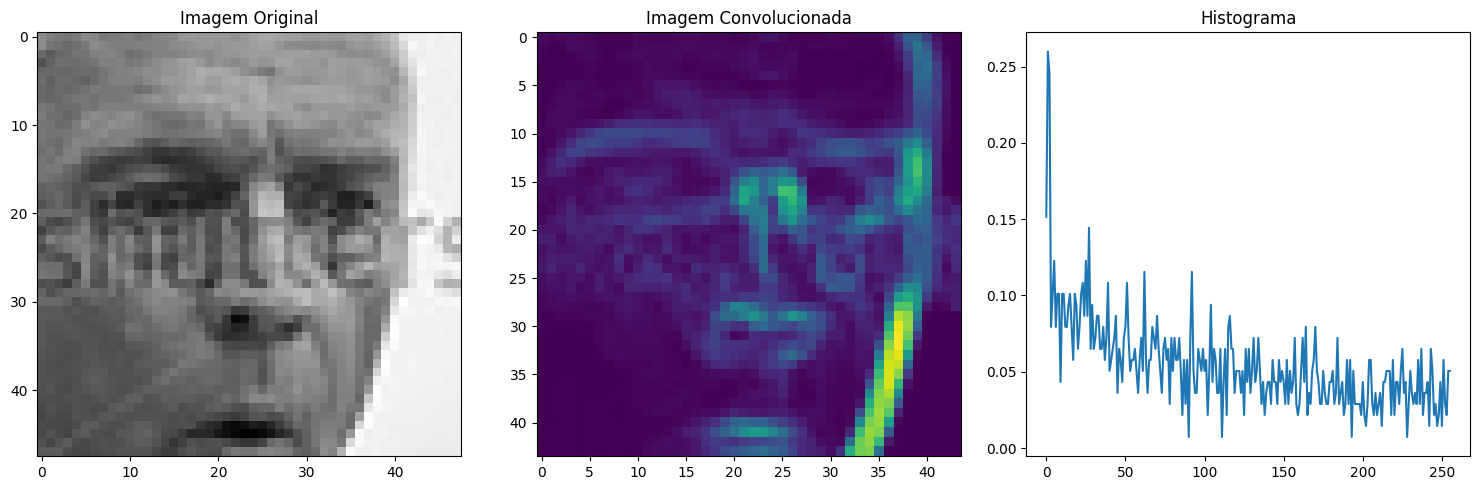

C:\Users\luizm\AppData\Local\Temp\ipykernel_4844\3134009525.py:16: RuntimeWarning: invalid value encountered in cast
  image_uint8 = np.uint8(image)


In [195]:
# Caminhos das pastas train e test (substitua pelo seu root_path)
root_path = './dataset'
train_dir = os.path.join(root_path, 'train')
test_dir = os.path.join(root_path, 'test')

# Mostrar exemplo de imagem original, convolucionada e histograma
example_image_path = os.path.join(train_dir, 'surprise', os.listdir(os.path.join(train_dir, 'surprise'))[0])
show_image_convolution_histogram(example_image_path)

# Passo 1: Carregar as imagens (apenas uma vez)
images_train, labels_train = load_images(train_dir)
images_test, labels_test = load_images(test_dir)

# Passo 2: Extrair features com LBP
X_lbp_train = extract_features(images_train, feature_type='lbp')
X_lbp_test = extract_features(images_test, feature_type='lbp')

Acurácia no teste: 0.24


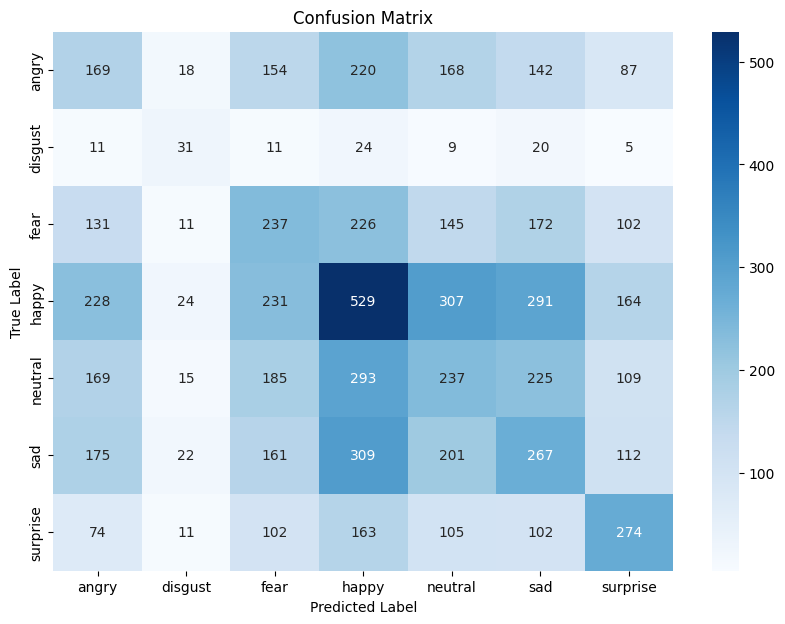

              precision    recall  f1-score   support

       angry       0.18      0.18      0.18       958
     disgust       0.23      0.28      0.26       111
        fear       0.22      0.23      0.23      1024
       happy       0.30      0.30      0.30      1774
     neutral       0.20      0.19      0.20      1233
         sad       0.22      0.21      0.22      1247
    surprise       0.32      0.33      0.33       831

    accuracy                           0.24      7178
   macro avg       0.24      0.25      0.24      7178
weighted avg       0.24      0.24      0.24      7178



In [196]:

# Treinar e avaliar o modelo com LBP
knn_lbp = KNeighborsClassifier(n_neighbors=1)
knn_lbp.fit(X_lbp_train, labels_train)

# Prever usando os dados de teste
y_lbp_pred_test = knn_lbp.predict(X_lbp_test)

# Avaliar a acurácia no teste
test_accuracy = accuracy_score(labels_test, y_lbp_pred_test)
print(f"Acurácia no teste: {test_accuracy:.2f}")

# Gerar a matriz de confusão
cm = confusion_matrix(labels_test, y_lbp_pred_test)

# Exibir a matriz de confusão
plot_confusion_matrix(cm, np.unique(labels_test))

# Mostrar o relatório de classificação
print(classification_report(labels_test, y_lbp_pred_test))


Acurácia no teste: 0.51


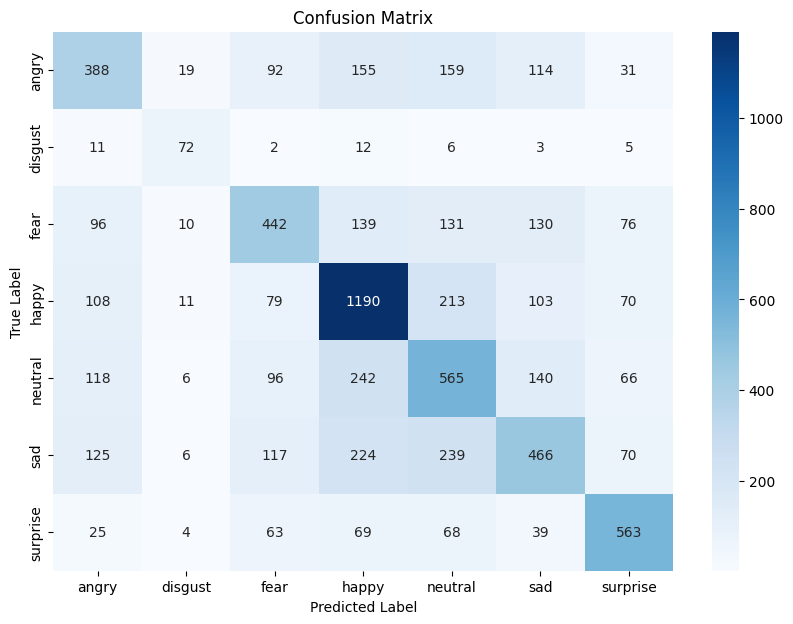

              precision    recall  f1-score   support

       angry       0.45      0.41      0.42       958
     disgust       0.56      0.65      0.60       111
        fear       0.50      0.43      0.46      1024
       happy       0.59      0.67      0.63      1774
     neutral       0.41      0.46      0.43      1233
         sad       0.47      0.37      0.42      1247
    surprise       0.64      0.68      0.66       831

    accuracy                           0.51      7178
   macro avg       0.52      0.52      0.52      7178
weighted avg       0.51      0.51      0.51      7178



In [197]:

# Passo 3: Extrair features com HOG
X_hog_train = extract_features(images_train, feature_type='hog')
X_hog_test = extract_features(images_test, feature_type='hog')

# Treinar e avaliar o modelo com HOG
knn_hog = KNeighborsClassifier(n_neighbors=1)
knn_hog.fit(X_hog_train, labels_train)

# Prever usando os dados de teste
y_hog_pred_test = knn_hog.predict(X_hog_test)

# Avaliar a acurácia no teste
test_accuracy = accuracy_score(labels_test, y_hog_pred_test)
print(f"Acurácia no teste: {test_accuracy:.2f}")

# Gerar a matriz de confusão
cm = confusion_matrix(labels_test, y_hog_pred_test)

# Exibir a matriz de confusão
plot_confusion_matrix(cm, np.unique(labels_train))

# Mostrar o relatório de classificação
print(classification_report(labels_test, y_hog_pred_test))